# Phase 1: *Data Preprocessing*

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from extra.cramers import cramers_corrected_stat
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import chi2_contingency


## Auxiliar functions

In [9]:
filepath = "../data/HC-universal.csv"
acc_log = pd.read_csv(filepath)
acc_log = acc_log[acc_log.columns[1:]]


print("### *** Access Log loaded *** ###")
print(acc_log.info())

### *** Access Log loaded *** ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153760 entries, 0 to 153759
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uname        153760 non-null  object
 1   position     153760 non-null  object
 2   uward        153760 non-null  object
 3   specialties  153760 non-null  object
 4   teams        153760 non-null  object
 5   agentfor     153760 non-null  object
 6   type         153760 non-null  object
 7   author       153760 non-null  object
 8   patient      153760 non-null  object
 9   topics       153760 non-null  object
 10  tratingTeam  153760 non-null  object
 11  rward        153760 non-null  object
 12  rname        153760 non-null  int64 
 13  ACTION       153760 non-null  int64 
dtypes: int64(2), object(12)
memory usage: 16.4+ MB
None


## 1 Data Splitting

### Auxiliar

In [10]:
def apply_cross_validation(acc_log, k, testSize, randomState=None):
    """Get all indices to split data."""
    if randomState != None:
        kfold = StratifiedShuffleSplit(n_splits=k, test_size=testSize,
                                       random_state=randomState)
    else:
        kfold = StratifiedShuffleSplit(n_splits=k, test_size=testSize)

    data_partition = kfold.split(acc_log, acc_log.ACTION)
    data_corpus = []  # List with all data partitions
    for train_data, test_data in data_partition:
        X_train, X_test = acc_log.iloc[train_data], acc_log.iloc[test_data]
        data_corpus.append([X_train, X_test])

    print("Cross-Validation - DONE")
    print("- k =", k)
    print("- Percentage Train-Test:", (1-testSize)*100, "-", testSize*100, "\n")

    return data_corpus

### Main

In [11]:
cross_validation_settings = {
    "k": 10,
    "test_size": 0.2,
    "random_state": 1
}

data_corpus = apply_cross_validation(acc_log, cross_validation_settings["k"],
                                     cross_validation_settings["test_size"],
                                     cross_validation_settings["random_state"])


# Selection of a split with the id_k ID.
id_k = 0
train_acc_log = data_corpus[id_k][0]
test_acc_log = data_corpus[id_k][1]

print("# Access requests in Train:", len(train_acc_log),
        " %: {:.2f}".format((len(train_acc_log)/(len(train_acc_log)+len(test_acc_log)))*100))
print("# Access requests in Test:", len(test_acc_log),
        " %: {:.2f}".format((len(test_acc_log)/(len(train_acc_log)+len(test_acc_log)))*100))
print("# Access requests:", len(train_acc_log)+len(test_acc_log))

del id_k, cross_validation_settings

Cross-Validation - DONE
- k = 10
- Percentage Train-Test: 80.0 - 20.0 

# Access requests in Train: 123008  %: 80.00
# Access requests in Test: 30752  %: 20.00
# Access requests: 153760


# 2 Handle missing values

### Auxiliar

In [ ]:
def handle_missing_values(acc_log):
    """ Handle missing and null data. """
    
    # Loop over column names.
    for col in acc_log.columns:
        

## 2 Missing and null data handle

In [12]:
acc_log["position"].value_counts(dropna=False)

doctor    124000
None       19840
nurse       9920
Name: position, dtype: int64

## 3.- Data Discretization

### Auxiliar

In [13]:
def search_numerical_categories(a_log, ignore_columns):
    """Check if there are numerical data in each column. The function returns
    a list of name column of all numerical data in the access log."""
    
    numerical_data_list = ["int64", "float32", "float64"]
    numerical_columns = []
    categorical_colums = 0
    
    for col in a_log.columns:
        if a_log[col].dtype in numerical_data_list and not col in ignore_columns:
            numerical_columns.append(col)
        else:
            categorical_colums += 1

    if categorical_colums == len(a_log.columns):
        return None

    return numerical_columns


### Main

In [14]:
# Check if there are numerical values in each column
ignore_columns = ["rname", "uname", "ACTION"]
answer = search_numerical_categories(acc_log, ignore_columns)

if answer != None:
    print("Column name with numerical values:")
    print("\t", answer)
else:
    print("PASO")


PASO


## 2.- Data Enginiering

In [15]:
acc_log

,uname,position,uward,specialties,teams,agentfor,type,author,patient,topics,tratingTeam,rward,rname,ACTION
0,oncNurse1,nurse,oncward,None,None,None,item,oncNurse1,oncPat1,oncology,oncTeam1,oncward,0,1
1,oncNurse1,nurse,oncward,None,None,None,item,oncNurse1,oncPat1,oncology,oncTeam1,carward,1,1
2,oncNurse1,nurse,oncward,None,None,None,item,oncNurse1,oncPat1,oncology,oncTeam2,oncward,2,1
3,oncNurse1,nurse,oncward,None,None,None,item,oncNurse1,oncPat1,oncology,oncTeam2,carward,3,1
4,oncNurse1,nurse,oncward,None,None,None,item,oncNurse1,oncPat1,oncology,carTeam1,oncward,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153755,carAgent1,None,None,None,None,carPat1,HR,carAgent1,oncPat1,cardiology,oncTeam2,carward,4915,0
153756,carAgent1,None,None,None,None,carPat1,HR,carAgent1,oncPat1,cardiology,carTeam1,oncward,4916,0
153757,carAgent1,None,None,None,None,carPat1,HR,carAgent1,oncPat1,cardiology,carTeam1,carward,4917,0
153758,carAgent1,None,None,None,None,carPat1,HR,carAgent1,oncPat1,cardiology,carTeam2,oncward,4918,0


(array([2., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([  9920.,  21328.,  32736.,  44144.,  55552.,  66960.,  78368.,
         89776., 101184., 112592., 124000.]),
 <BarContainer object of 10 artists>)

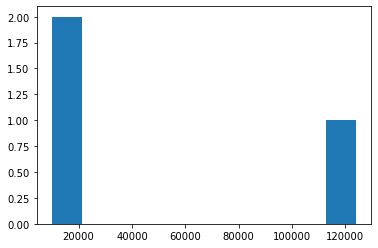

In [16]:
plt.hist(acc_log.position.value_counts())

In [17]:
acc_log.columns

Index(['uname', 'position', 'uward', 'specialties', 'teams', 'agentfor',
       'type', 'author', 'patient', 'topics', 'tratingTeam', 'rward', 'rname',
       'ACTION'],
      dtype='object')

In [18]:
import scipy.stats as ss

def cramers_corrected_stat2(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]    
    n = sum(confusion_matrix.sum())    
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    if min( (kcorr-1), (rcorr-1)) <= 0:
        return -1
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [19]:
cramers_matrix = []

for x_ in acc_log.columns[:-1]:
    row_to_add = []
    for y_ in acc_log.columns[:-1]:
        if x_ == y_:
            row_to_add.append(1.0)
        else:
            conff_mx = pd.crosstab(acc_log[x_], acc_log[y_])
            row_to_add.append(cramers_corrected_stat2(conff_mx))
    cramers_matrix.append(row_to_add)
print("DONE!")

DONE!


<AxesSubplot:title={'center':"Cramér's V correlation."}>

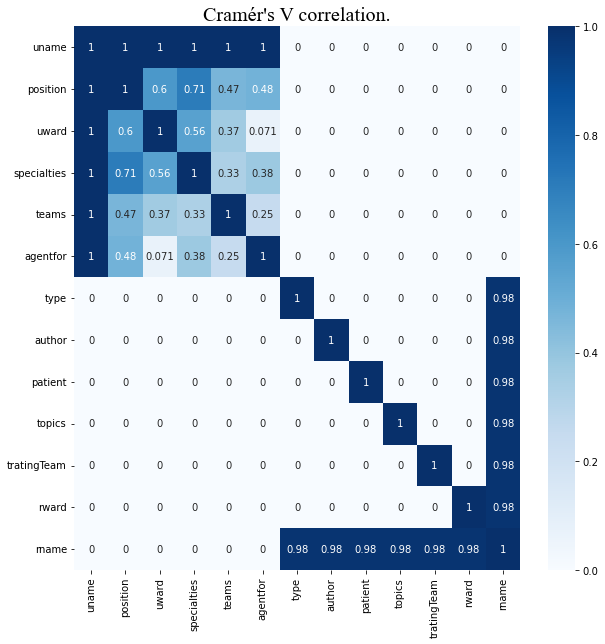

In [21]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,10))
fontdict_title = {'fontsize': 20, 'fontname': 'Times New Roman'}
ax.set_title("Cramér's V correlation.", fontdict=fontdict_title)
sns.heatmap(cramers_matrix, xticklabels=acc_log.columns[:-1], 
            yticklabels=acc_log.columns[:-1], cmap="Blues", annot=True)